In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit

In [2]:
sub = pd.read_csv('data/sample_submission.csv')
test = pd.read_csv('data/test.csv')
train = pd.read_csv('data/train.csv')

In [3]:
sub.head()

,row_id,num_sold
0,70128,100
1,70129,100
2,70130,100
3,70131,100
4,70132,100


In [4]:
test.head()

,row_id,date,country,store,product
0,70128,2021-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques
1,70129,2021-01-01,Belgium,KaggleMart,Kaggle Getting Started
2,70130,2021-01-01,Belgium,KaggleMart,Kaggle Recipe Book
3,70131,2021-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose
4,70132,2021-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques


In [5]:
train.head()

,row_id,date,country,store,product,num_sold
0,0,2017-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques,663
1,1,2017-01-01,Belgium,KaggleMart,Kaggle Getting Started,615
2,2,2017-01-01,Belgium,KaggleMart,Kaggle Recipe Book,480
3,3,2017-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose,710
4,4,2017-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques,240


In [6]:
train['country'].unique()

array(['Belgium', 'France', 'Germany', 'Italy', 'Poland', 'Spain'],
      dtype=object)

In [7]:
train['store'].unique()

array(['KaggleMart', 'KaggleRama'], dtype=object)

In [8]:
train['product'].unique()

array(['Kaggle Advanced Techniques', 'Kaggle Getting Started',
       'Kaggle Recipe Book', 'Kaggle for Kids: One Smart Goose'],
      dtype=object)

In [9]:
train['date'].unique()

array(['2017-01-01', '2017-01-02', '2017-01-03', ..., '2020-12-29',
       '2020-12-30', '2020-12-31'], dtype=object)

In [10]:
train.head()

,row_id,date,country,store,product,num_sold
0,0,2017-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques,663
1,1,2017-01-01,Belgium,KaggleMart,Kaggle Getting Started,615
2,2,2017-01-01,Belgium,KaggleMart,Kaggle Recipe Book,480
3,3,2017-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose,710
4,4,2017-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques,240


In [11]:
train.drop('row_id', inplace=True, axis=1)
test.drop('row_id', inplace=True, axis=1)
train["country"] = train["country"].astype("category")
train["store"] = train["store"].astype("category")
train["product"] = train["product"].astype("category")

In [43]:
tscv = TimeSeriesSplit()
tscv

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None)

In [13]:
y, X = train['num_sold'], train.drop('num_sold', axis=1)

In [14]:
for train_index, test_index in tscv.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    break

TRAIN: [    0     1     2 ... 11685 11686 11687] TEST: [11688 11689 11690 ... 23373 23374 23375]


In [15]:
X_train

,date,country,store,product
0,2017-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques
1,2017-01-01,Belgium,KaggleMart,Kaggle Getting Started
2,2017-01-01,Belgium,KaggleMart,Kaggle Recipe Book
3,2017-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose
4,2017-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques
...,...,...,...,...
11683,2017-09-01,Germany,KaggleMart,Kaggle for Kids: One Smart Goose
11684,2017-09-01,Germany,KaggleRama,Kaggle Advanced Techniques
11685,2017-09-01,Germany,KaggleRama,Kaggle Getting Started
11686,2017-09-01,Germany,KaggleRama,Kaggle Recipe Book


In [16]:
X_train = pd.get_dummies(X_train, columns=['country', 'store', 'product'])
X_test = pd.get_dummies(X_test, columns=['country', 'store', 'product'])

In [17]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11688 entries, 0 to 11687
Data columns (total 13 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   date                                      11688 non-null  object
 1   country_Belgium                           11688 non-null  uint8 
 2   country_France                            11688 non-null  uint8 
 3   country_Germany                           11688 non-null  uint8 
 4   country_Italy                             11688 non-null  uint8 
 5   country_Poland                            11688 non-null  uint8 
 6   country_Spain                             11688 non-null  uint8 
 7   store_KaggleMart                          11688 non-null  uint8 
 8   store_KaggleRama                          11688 non-null  uint8 
 9   product_Kaggle Advanced Techniques        11688 non-null  uint8 
 10  product_Kaggle Getting Started            1168

In [18]:
X_train['date'] = pd.to_datetime(X_train['date']).astype('int64') // 10 ** 9
X_test['date'] = pd.to_datetime(X_test['date']).astype('int64') // 10 ** 9

In [24]:
dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
dtest = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)
param = {
    'max_depth': 2,
    'eta': 1,
    'nthread': 4,
    'eval_metric': 'auc'
}

In [36]:
def smape(predt: np.ndarray, dtrain: np.ndarray):
    s = 100 / len(predt) * np.sum(
        2 * np.abs(dtrain - predt) / (np.abs(predt) + np.abs(dtrain))
    )

    return s


def smape_obj(predt: np.ndarray, dtrain: xgb.DMatrix):
    s = smape(
        predt,
        dtrain.get_label()
    )

    return 'smape', s

In [32]:
num_round = 10
model = xgb.train(param, dtrain, num_round)

In [33]:
ypred = model.predict(dtest)

In [34]:
smape(y_test, ypred)

19.95445567022474

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

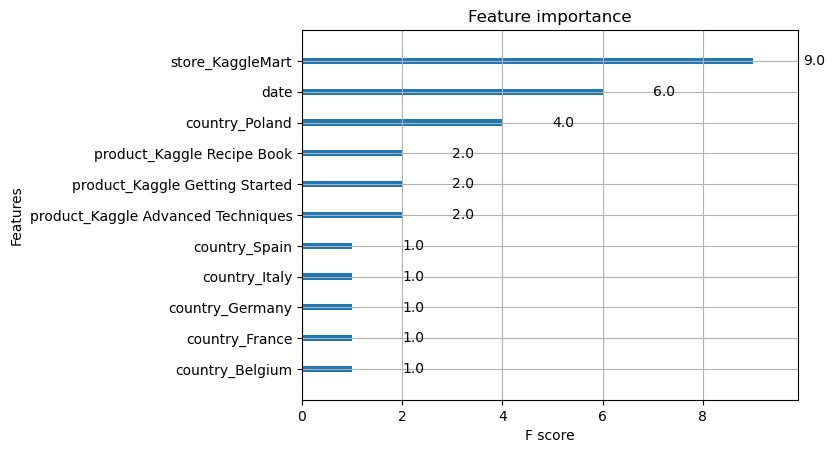

In [44]:
xgb.plot_importance(model)

In [42]:
num_round = 10
results = []
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # clean data
    X_train = pd.get_dummies(X_train, columns=['country', 'store', 'product'])
    X_test = pd.get_dummies(X_test, columns=['country', 'store', 'product'])
    X_train['date'] = pd.to_datetime(X_train['date']).astype('int64') // 10 ** 9
    X_test['date'] = pd.to_datetime(X_test['date']).astype('int64') // 10 ** 9

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    m = xgb.train(param, dtrain, num_round)
    y_pred = m.predict(dtest)
    results.append(smape(y_test, y_pred))

# np.array(results).mean()
results

ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, The experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:date: object